In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [3]:
!pip install datasets

# SECTION 1: Setup and Import Libraries

In [4]:
from google.colab import drive  # For mounting Google Drive
# Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os  # For interacting with the operating system
# Set Kaggle API access using the JSON file stored in Google Drive
kaggle_json_path = '/content/drive/MyDrive/Pytorch_projects/kaggle.json'  # Path to Kaggle API key
os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname(kaggle_json_path)  # Set the environment variable for Kaggle API
!chmod 600 {kaggle_json_path}  # Change file permissions to secure the Kaggle API key

In [6]:
# Download and unzip the IMDB movie review dataset from Kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip  # Unzip the downloaded file

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [7]:
# Importing necessary libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer  # Hugging Face libraries
from datasets import Dataset  # For handling datasets in Hugging Face format
import pandas as pd  # For data manipulation using pandas
import torch  # For PyTorch deep learning operations
import numpy as np  # For numerical operations
import re  # For regular expression operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For creating heatmaps and other visualizations
from sklearn.metrics import confusion_matrix, classification_report  # For model evaluation
import evaluate  # For loading evaluation metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau  # Keras callbacks for model training



# SECTION 2: Load & Preprocess Dataset

In [8]:
# Load the IMDB dataset into a pandas DataFrame
df = pd.read_csv('/content/IMDB Dataset.csv')

In [9]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [10]:
df.info()  # Display dataset information like column names and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
# Encode sentiment labels (positive = 1, negative = 0)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [12]:
# Function to clean text by removing HTML tags and non-alphanumeric characters
def clean_review(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation and special characters
    return text.lower().strip()  # Convert to lowercase and strip extra spaces

In [13]:
# Apply the cleaning function to the 'review' column
df['review'] = df['review'].apply(clean_review)

In [15]:
# Create a Hugging Face Dataset object for easy tokenization
hf_dataset = Dataset.from_pandas(df[['review', 'sentiment']])
hf_dataset  # Display dataset preview

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# SECTION 3: Tokenization and Dataset Splitting

In [16]:
checkpoint = "bert-base-uncased"  # Use pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)  # Load the BERT tokenizer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)  # Load BERT model for classification with 2 labels (positive/negative)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Function to tokenize the reviews and align with the labels
def tokenize_function(example):
    result = tokenizer(
        example["review"], padding="max_length", truncation=True, max_length=256  # Tokenize and pad/truncate text to max length of 256
    )
    result["labels"] = example["sentiment"]  # Add labels to the tokenized result
    return result

In [18]:
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [19]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.3, seed=42)

In [20]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
})

In [21]:
val_test = tokenized_dataset['test'].train_test_split(test_size=0.5, seed=42)

In [22]:
val_test

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
})

In [23]:
tokenized_dataset['val'] = val_test['train']
tokenized_dataset['test'] = val_test['test']

In [24]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
    val: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
})

# SECTION 4: Metrics and Training Configuration

In [25]:
# Load the accuracy metric from Hugging Face's 'evaluate' library
accuracy_metric = evaluate.load("accuracy")

# Function to compute accuracy during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred  # Get predicted logits and true labels
    predictions = np.argmax(logits, axis=-1)  # Get the predicted class (highest logit value)
    return accuracy_metric.compute(predictions=predictions, references=labels)  # Return accuracy

In [26]:
# Set up the training arguments with configuration for training and evaluation
training_args = TrainingArguments(
    output_dir="./bert_results",  # Directory to save model and logs
    run_name="bert-imdb",  # Name of the training run
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    save_total_limit=1,  # Keep only the best model during training
    load_best_model_at_end=True,  # Load the best model after training
    metric_for_best_model="eval_loss",  # Use eval loss to determine the best model
    greater_is_better=False,  # Lower eval loss is better
    num_train_epochs=10,  # Number of epochs to train
    per_device_train_batch_size=32,  # Batch size for training
    per_device_eval_batch_size=64,  # Batch size for evaluation
    logging_dir="./logs",  # Directory for logging
    report_to="none"  # Disable logging to external systems (e.g., TensorBoard)
)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
# Custom callback to log training metrics in a pandas DataFrame
class PandasLoggerCallback(TrainerCallback):
    def __init__(self):
        self.logs = []  # Initialize empty list to store logs

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:  # Check if metrics are available
            metrics_copy = metrics.copy()  # Create a copy of the metrics
            metrics_copy["epoch"] = state.epoch  # Add the current epoch
            self.logs.append(metrics_copy)  # Append the metrics log

    def to_dataframe(self):
        return pd.DataFrame(self.logs)  # Convert logs to pandas DataFrame

# SECTION 5: Training the Model

In [ ]:
pandas_logger = PandasLoggerCallback()  # Initialize the logger callback

In [30]:
# Initialize the Trainer with the model, training arguments, datasets, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],  # Training dataset
    eval_dataset=tokenized_dataset['val'],  # Validation dataset
    compute_metrics=compute_metrics,  # Function to compute accuracy
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2), pandas_logger]  # Add early stopping and logging
)

In [31]:
trainer.train()  # Train the model

Epoch,Training Loss,Validation Loss,Accuracy
1,0.239000,0.212777,0.913867
2,0.136800,0.231545,0.924533
3,0.075600,0.320374,0.924800


TrainOutput(global_step=3282, training_loss=0.16019315388346503, metrics={'train_runtime': 4910.9136, 'train_samples_per_second': 71.27, 'train_steps_per_second': 2.228, 'total_flos': 1.38133304064e+16, 'train_loss': 0.16019315388346503, 'epoch': 3.0})

In [32]:
# Evaluate the model on the test dataset
trainer.evaluate(tokenized_dataset['test'])


{'eval_loss': 0.21347567439079285,
 'eval_accuracy': 0.9169333333333334,
 'eval_runtime': 112.4606,
 'eval_samples_per_second': 66.69,
 'eval_steps_per_second': 1.049,
 'epoch': 3.0}

In [33]:
# Save training logs and model to Google Drive
log_df = pandas_logger.to_dataframe()
log_df.to_csv("/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Logs/bert_training_log.csv", index=False)

# Save the trained model and tokenizer for later use
trainer.save_model("/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/bert_best_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/bert_best_model")

('/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/bert_best_model/tokenizer_config.json',
 '/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/bert_best_model/special_tokens_map.json',
 '/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/bert_best_model/vocab.txt',
 '/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/bert_best_model/added_tokens.json',
 '/content/drive/MyDrive/Pytorch_projects/IMDB_Dataset_of_50K_Movie_Reviews/Model/bert_best_model/tokenizer.json')

# SECTION 6: Plot Training Results

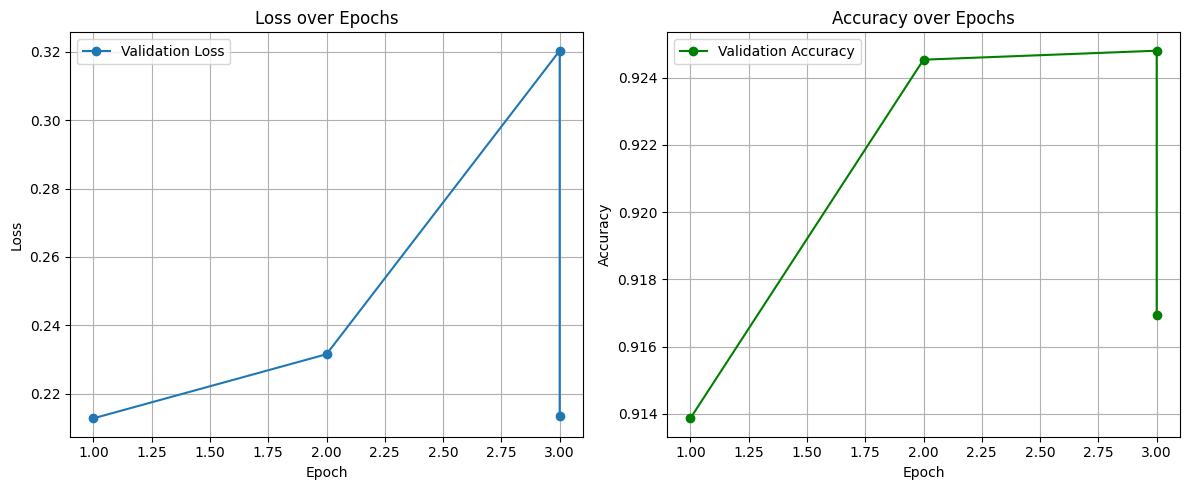

In [34]:
# Plot training loss and accuracy over epochs
plt.figure(figsize=(12, 5))

# Plot validation loss
plt.subplot(1, 2, 1)
plt.plot(log_df["epoch"], log_df["eval_loss"], marker='o', label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(log_df["epoch"], log_df["eval_accuracy"], marker='o', color='green', label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()  # Display the plots

# SECTION 7: Evaluate Performance with Confusion Matrix and Classification Report

In [ ]:
# Make predictions on the test dataset
predictions = trainer.predict(tokenized_dataset['test'])
y_true = predictions.label_ids  # Get true labels
y_pred = np.argmax(predictions.predictions, axis=1)  # Get predicted labels

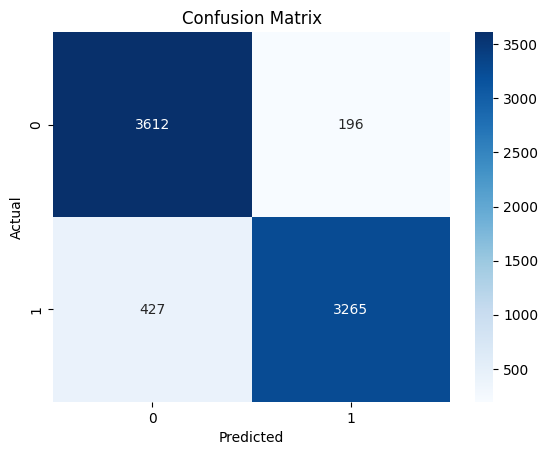

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix heatmap
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()  # Display the heatmap


In [36]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))  # Print classification report


Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.95      0.92      3808
    positive       0.94      0.88      0.91      3692

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



##Load Model
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained("/content/bert_best_model")
model = BertForSequenceClassification.from_pretrained("/content/bert_best_model")
